# NSSP project 1
### preprocessing and GLM analysis

In this notebook, we aims to study the neural processing of emotionally provocative auditory stimuli.

# Setup the notebook

### Import, setup FSL

In [1]:
%gui wx
import sys
import os
import os.path as op

#utility functions from previous labs
import utils 

#to download the dataset from openneuro
import subprocess
import openneuro

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt

from fsl.wrappers import concatxfm,applyxfm,applyxfm4D

from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

#concatenation
import mne_nirs
import nilearn
from nilearn.image import concat_imgs, mean_img
import nibabel as nib

import ants

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

import matplotlib.pyplot as plt

#GLM
import nibabel as nib
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map,plot_design_matrix,plot_contrast_matrix
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn import datasets
from matplotlib.colors import ListedColormap

Gtk-Message: 14:35:14.727: Failed to load module "canberra-gtk-module"


In [2]:
####################
# Setup FSL path
####################
utils.loadFSL()
################
# Start FSLeyes 
################
fsleyesDisplay = utils.FSLeyesServer()
fsleyesDisplay.show()

14:35:17: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:35:17: Debug: Adding duplicate animation handler for '1' type
14:35:17: Debug: Adding duplicate animation handler for '2' type
14:35:17: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:35:17: Debug: Adding duplicate animation handler for '1' type
14:35:17: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:10983): Gtk-CRITICAL **: 14:35:17.627: gtk_window_resize: assertion 'height > 0' failed


In [3]:
#We define the parameters RERUN to rerun all the transform, if false it will use the saved files.
RERUN = False

In [4]:
import xml.etree.ElementTree as ET
def display_atlas_corresp(atlas_xml_path):
    """
    Given a path to an XML, extract all region labels and print their correspondance with numerical values
    of the nifti atlas file. (FSL-based convention)

    Parameters
    ----------
    atlas_xml_path: string
        Path to an XML atlas path, from which to extract all labels.
    """
    root=ET.parse(atlas_xml_path).getroot()
    for type_tag in root.findall('data/label'):
        value = type_tag.get('index')
        display('{} : {}'.format(int(value)+1, type_tag.text))

### Download and explore the dataset

In [5]:
#download the dataset

#"https://openneuro.org/datasets/ds000171/versions/00001"
dataset= 'ds000171'
version = '00001'
subject = 'sub-control01'
subjectID = 'control01'

#path to save
sample_path = "dataset"
utils.mkdir_no_exist(sample_path)

# Construct paths
bids_root = os.path.join(os.path.abspath(""), sample_path, dataset)
deriv_root = os.path.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

#folder for derivative and preprocess
utils.mkdir_no_exist(deriv_root)
utils.mkdir_no_exist(preproc_root)
utils.mkdir_no_exist(op.join(preproc_root, subject))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'anat'))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'func'))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'fmap'))

#run this line only if you dont have the dataset 
if RERUN :
    subprocess.run(["openneuro-py", "download", "--dataset", dataset, "--target_dir", bids_root,"--include",subject], check=True)

In [6]:
# explore the dataset folder
print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- .ipynb_checkpoints/
|------ T1w-checkpoint.json
|------ dataset_description-checkpoint.json
|------ task-music_bold-checkpoint.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mask_handmodif.nii.gz
|--------------- sub-control01_T1w_mni.mat
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|------------ fmap/
|------------ func

In [7]:
data_description = utils.get_json_from_file(op.join(bids_root,'dataset_description.json'))
data_description

data_task = utils.get_json_from_file(op.join(bids_root,'task-music_bold.json'))
data_task

{'TaskName': 'Music',
 'RepetitionTime': 3.0,
 'EchoTime': 0.025,
 'FlipAngle': 90.0,
 'SequenceName': 'EPI BOLD',
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Skyra',
 'MagneticFieldStrength': 3.0,
 'ParallelImagingReductionFactor': 0,
 'SliceTimingComputationMethod': '(slicenum*RepetitionTime/TotalSlices), interleaved according to Siemens even-numbered slice convention (even slices first).',
 'SliceTiming': [1.5,
  0.0,
  1.56,
  0.06,
  1.62,
  0.12,
  1.68,
  0.18,
  1.74,
  0.24,
  1.8,
  0.3,
  1.86,
  0.36,
  1.92,
  0.42,
  1.98,
  0.48,
  2.04,
  0.54,
  2.1,
  0.6,
  2.16,
  0.66,
  2.22,
  0.72,
  2.28,
  0.78,
  2.34,
  0.84,
  2.4,
  0.9,
  2.46,
  0.96,
  2.52,
  1.02,
  2.58,
  1.08,
  2.64,
  1.14,
  2.7,
  1.2,
  2.76,
  1.26,
  2.82,
  1.32,
  2.88,
  1.38,
  2.94,
  1.44]}

In [8]:
# explore anatomical
# fsleyesDisplay.resetOverlays()
# fsleyesDisplay.load(op.join(bids_root, subject,'anat','sub-control01_T1w.nii.gz'))

# explore one functional 
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(op.join(bids_root, subject,'func','sub-control01_task-music_run-1_bold.nii.gz'))

# Pre-processing

Prior to analysis we need to pre process the data.
We will standardize each run of interest of sub-control01 and concatenate all together.<br/>
Then,we will apply standard preprocessing steps.

<b>Anatomical preprocessing</b>
1. Skull stripping
2. segmentation
3. Coregistration & Normalisation

<b>functional preprocessing</b>
1. standardisation
2. concatenation
3. motion correction
4. Coregistration & normalisation
5. smoothing

## Anatomical preprocessing

### 1.1 Skull stripping

In [9]:
#Skull stripping 
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mask'.format(subjectID))

if RERUN :
    get_skull_stripped_anatomical(bids_root, preproc_root, subjectID,robust=True)

In [10]:
#display the mask and observe that the skull is correctely removed
#fsleyesDisplay.load(resulting_mask_path)

After verification and manual corrections, we consider the skull tripping mask good enough. We apply the mask.
Attention : if not handmodified, do


In [11]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """
    Apply a mask
    """
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w'.format(subjectID)) # The original brain
betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subjectID)) # The brain without skull is in the derivatives folder
#resulting_mask_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mask_handmodif'.format(subjectID)) # The mask to use

if RERUN :
    apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [12]:
#display the brain without the skull
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(betted_brain_path)

### 1.2 Tissue Segmentation

In [13]:
#segmentation
segmentation_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_fast'.format(subjectID))

if RERUN : 
    [os.remove(f) for f in glob.glob(op.join(preproc_root, subject, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
    fast(imgs=[betted_brain_path], out=segmentation_path, n_classes=3)

In [14]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- .ipynb_checkpoints/
|------ T1w-checkpoint.json
|------ dataset_description-checkpoint.json
|------ task-music_bold-checkpoint.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mask_handmodif.nii.gz
|--------------- sub-control01_T1w_mni.mat
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|------------ fmap/
|------------ func

In [15]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(betted_brain_path)
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_0*'))[0])
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_1*'))[0])
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_2*'))[0])
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

The segmentation correctely separated grey matter, white matter and cerebrospinal fluid.

### 1.3 Anatomical normalization

In [16]:
#Coregistration

mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz'))

target = betted_brain_path
reference = mni_template

#FLIRT Linear
anat_to_mni = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mni'.format(subjectID))
anat_to_mni_mat = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mni.mat'.format(subjectID))
if RERUN :
    flirt(target, reference, out=anat_to_mni,omat=anat_to_mni_mat)

#FNIRT non-linear
anat_to_mni_Ants = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subjectID))
if RERUN :
    moving_image = ants.image_read(target + '.nii.gz')
    fixed_image = ants.image_read(reference)

    transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN' )
    warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
    ants.image_write(warpedImage, anat_to_mni_Ants)

In [17]:
#display the coregistred brain
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(reference)
#fsleyesDisplay.load(result)
#fsleyesDisplay.load(resultAnts)

This step finish the anatomical preprocessing.

## functionnal preprocessing

### 1.1 Volume removal (check if necessary)

Text(0, 0.5, 'Mean voxel intensity')

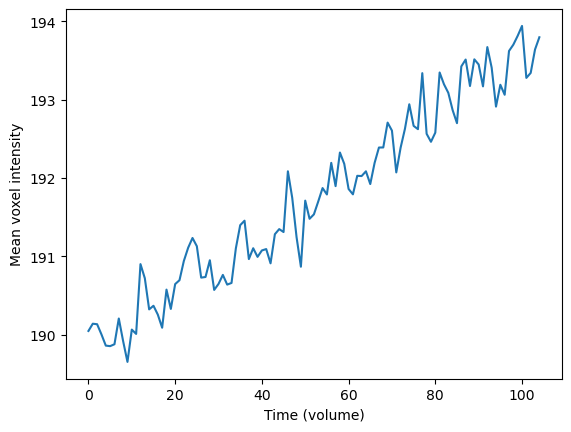

In [18]:
plt.plot(nib.load(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
#we see no need of volume removal here

### 1.2 Standardization

In [19]:
print_dir_tree(op.join(bids_root, subject, 'func')) #functionnal directory

|func/
|--- sub-control01_task-music_run-1_bold.nii.gz
|--- sub-control01_task-music_run-1_events.tsv
|--- sub-control01_task-music_run-2_bold.nii.gz
|--- sub-control01_task-music_run-2_events.tsv
|--- sub-control01_task-music_run-3_bold.nii.gz
|--- sub-control01_task-music_run-3_events.tsv
|--- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--- sub-control01_task-nonmusic_run-4_events.tsv
|--- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--- sub-control01_task-nonmusic_run-5_events.tsv
|--- .ipynb_checkpoints/
|------ sub-control01_task-music_run-2_events-checkpoint.tsv


In [20]:
import re

func_dir = op.join(bids_root, subject, 'func')
pattern = re.compile(r'^sub-control01_task-music_run-\d+_bold\.nii\.gz$')
file_paths = []

# Check if the directory exists
if os.path.exists(func_dir):
    for file_name in os.listdir(func_dir):
        # If the file name matches the pattern, add it to the array with the full path
        if pattern.match(file_name):
            full_path = os.path.join(func_dir, file_name)
            file_paths.append(full_path)
            mri = nib.load(full_path)
            print(mri.shape)


file_paths.sort()

# Output the array of all runs
print(len(file_paths))
print(file_paths)

(80, 80, 50, 105)
(80, 80, 50, 105)
(80, 80, 50, 105)
3
['/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz']


In [21]:
#fsleyesDisplay.resetOverlays()
#for file in file_paths :
#    fsleyesDisplay.load(file)

In [22]:
def standardization(input_file):
    """
    Apply z-score standardization to fMRI data

    Parameters:
    input_file (str): Path to the input
    output_file (str): Path to save the standardized output 
    """
    # Check if input file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file not found: {input_file}")

    extract_name = '_'.join(os.path.basename(input_file).split('_')[1:]).rsplit('.', 2)[0]
    print(extract_name)
    output_file = os.path.join(preproc_root, subject, 'func', 'sub-{}_{}_standardize.nii'.format(subjectID,extract_name))
    
    # Load the image data
    img = nib.load(input_file)
    data = img.get_fdata()

    # Calculate global mean and standard deviation
    global_mean = data.mean()
    global_std = data.std()

    # Standardize the data (avoid division by zero)
    standardized_data = (data - global_mean) / global_std if global_std > 0 else data

    # Create a new Nifti image with the standardized data and save
    standardized_img = nib.Nifti1Image(standardized_data, img.affine, img.header)
    nib.save(standardized_img, output_file)

    return output_file
# Example usage:
stand_file_paths = []
for file in file_paths :
    stand_file_paths.append(standardization(file))

stand_file_paths

task-music_run-1_bold
task-music_run-2_bold
task-music_run-3_bold


['/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_standardize.nii',
 '/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_standardize.nii',
 '/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_standardize.nii']

### 1.3 Concatenation

In [23]:
#fsleyesDisplay.resetOverlays()
#for file in stand_file_paths :
#    fsleyesDisplay.load(file)

In [24]:
#concatenation

concat_path = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold'.format(subjectID))

if  RERUN :
    fmri_img = concat_imgs(stand_file_paths)
    nib.save(fmri_img, concat_path)

### 1.4  Motion correction

In [25]:
#motion correction

path_moco_data = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco'.format(subjectID))

if RERUN :
    mcflirt(infile=concat_path,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

In [26]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(concat_path)
#fsleyesDisplay.load(path_moco_data)

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002982,0.003060,-0.000131,-0.060372,-0.515789,-0.473079
1,-0.003427,0.003060,-0.000229,-0.074698,-0.494173,-0.463364
2,-0.003242,0.003177,-0.000197,-0.059108,-0.472619,-0.450286
3,-0.003235,0.003175,-0.000380,-0.074562,-0.482960,-0.463447
4,-0.002639,0.003060,-0.000313,-0.071470,-0.468797,-0.494620
...,...,...,...,...,...,...
310,0.009004,-0.000046,-0.001964,-0.087061,0.395507,0.240721
311,0.009023,-0.000047,-0.002066,-0.089177,0.372734,0.226257
312,0.009100,-0.000411,-0.002086,-0.087188,0.399878,0.224917
313,0.008964,-0.000582,-0.002106,-0.103967,0.370314,0.211559


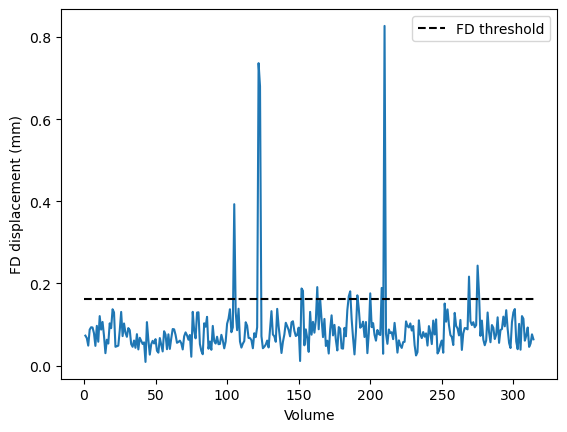

[105 122 123 152 153 163 165 185 186 191 200 208 210 269 275 276]


In [27]:
def inspect_motion_correction(path):
    """
    Function to visualise how much each volume have to be motion-corrected.
    """
    
    #extract parameters
    parameters =pd.read_csv(path, sep='  ', header=None, engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])
    display(parameters)

    #calculate frame-wise displacement
    framewise_diff = parameters.diff().iloc[1:]
    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]

    # Estimating displacement on a 50mm radius sphere
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1).to_numpy()

    #threshold
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

    #plot for each volume
    plt.plot(list(range(1, fd.size+1)), fd)
    plt.xlabel('Volume')
    plt.ylabel('FD displacement (mm)')
    plt.hlines(threshold, 0, len(parameters),colors='black', linestyles='dashed', label='FD threshold')
    plt.legend()
    plt.show()

    print(np.where(fd > threshold)[0] + 1)

path_moco_param = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco.par'.format(subjectID))
inspect_motion_correction(path_moco_param)

We have some volume with high motion. However, we have to take into account that there is 3 run in the data. From precedent analysis, we have 105 scan per run. 
We thus expect high motion around run 105 and 210 !

However, we have a big motion artefact around volume 122 and 3 small ones around volumes 152, 269 and 275. We will have to explore further volume 122.

![Alt text](pictures/artefact122.png)

There is a line artefact. 

### 1.5  Smoothing

In [28]:
#smoothing
smoothed_path = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_smoothed-4mm'.format(subjectID))

if RERUN:
    cmd = 'fslmaths {} -s {} {}'.format(path_moco_data, 4/2.3548, path_moco_data)
    subprocess.run(['fslmaths',path_moco_data, '-s', str(4/2.3548), '{}_smoothed-4mm'.format(path_moco_data)])

In [29]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(smoothed_path)

### 1.5  Coregistration and normalization : find functional to anatomical to MNI space matrix

In [30]:
subprocess.run(['fslroi'])


Usage: fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize>
       fslroi <input> <output> <tmin> <tsize>

       fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize> <tmin> <tsize>
Note: indexing (in both time and space) starts with 0 not 1! Inputting -1 for a size will set it to the full image extent for that dimension.


CompletedProcess(args=['fslroi'], returncode=1)

In [31]:
#EPI coregistration
#functional to anatomical
whole_t1 = anatomical_path
skull_stripped_t1 = betted_brain_path
func_to_anat = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_bbr'.format(subjectID))
func_to_anat_mat = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_bbr.mat'.format(subjectID))

ref_vol_name =  op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_vol_middle'.format(subjectID))

fslroi(path_moco_data, ref_vol_name, str(157), str(1))

white_matter_segmentation = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_fast_pve_2.nii.gz'.format(subjectID)) # We provide the white matter segmentation

if RERUN :
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(func_to_anat),
               '--wmseg={}'.format(white_matter_segmentation)])

In [32]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(skull_stripped_t1)
#fsleyesDisplay.load(func_to_anat)

In [33]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

cleanup_epi_reg(op.join(preproc_root, subject, 'func'))

Reminder that we normalized the anatomical data to the MNI space. The transformed data is anat_to_mni.

We have motion corrected the functional data, and coregistred it to the anatomical, resulting to func_to_anat.

The corresponding matrix are :
- functional to anat : func_to_anat_mat
- anat to mni : anat_to_mni_mat

We can now combine the transform and apply them 

In [34]:
func_to_mni_mat = op.join(preproc_root, subject, 'func', 'sub-{}_all_transforms.mat'.format(subjectID))

if RERUN :
    concatxfm(atob=func_to_anat_mat, btoc=anat_to_mni_mat, atoc=func_to_mni_mat)

# GLM analysis

### Experimental design matrix

In [35]:
#for one run
run_1 = os.path.join(bids_root, subject, 'func', 'sub-{}_task-music_run-1_events.tsv'.format(subjectID))
pd.read_csv(run_1,sep = '\t')

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [36]:
#for all runs 

func_dir = op.join(bids_root, subject, 'func')
pattern = re.compile(r'^sub-control01_task-music_run-\d+_events\.tsv$')
#pattern = re.compile(r'^sub-control01_task-music_run-2_events\.tsv$')

file_paths = []

# Check if the directory exists
if os.path.exists(func_dir):
    for file_name in os.listdir(func_dir):
        # If the file name matches the pattern, add it to the array with the full path
        if pattern.match(file_name):
            full_path = os.path.join(func_dir, file_name)
            file_paths.append(full_path)
file_paths.sort()
# Output the array of all runs
print(len(file_paths))
print(file_paths)

events = pd.DataFrame()
for file in file_paths:
    new_event = pd.read_csv(file,sep = '\t')
    if len(events) > 0 :
        last_onset = events.iloc[-1].onset
        new_event['onset'] += last_onset
    events = pd.concat([events, new_event], ignore_index=True)
events

3
['/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_events.tsv', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_events.tsv']


,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [37]:
# Specify the GLM
# according to task-music_bold.json, the TR is 3 sec
fmri_glm = FirstLevelModel(t_r=3.0,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

fmri_glm_outlier = FirstLevelModel(t_r=3.0,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

fmri_glm_drift = FirstLevelModel(t_r=3.0,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
dpath = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_smoothed-6mm.nii.gz'.format(subjectID))
fmri_glm = fmri_glm.fit(dpath, events)

<Axes: label='conditions', ylabel='scan number'>

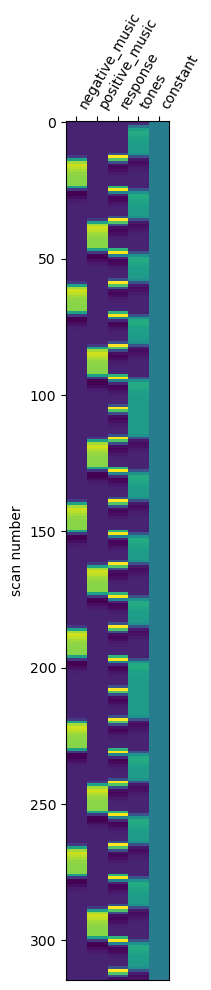

In [38]:
design_mat = fmri_glm.design_matrices_[0]
plot_design_matrix(design_mat)

<Axes: label='conditions', ylabel='scan number'>

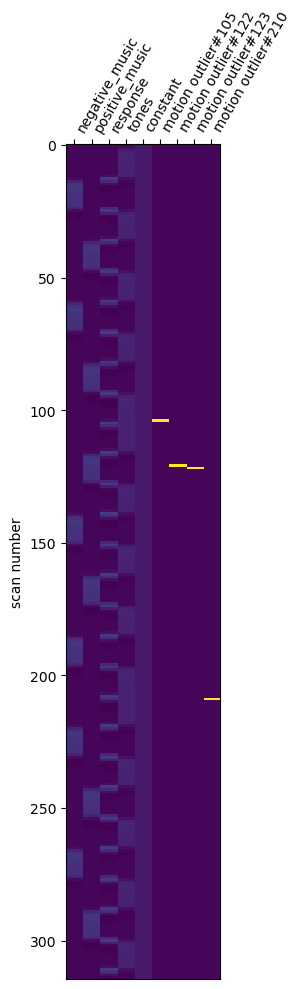

In [39]:
design_mat_outlier = design_mat.copy()

for outlier in [104,121,122,209] :
    reg = np.zeros((315,))*0.0
    reg[outlier] = 1.0
    design_mat_outlier['motion outlier#' + str(outlier+1)] = reg

plot_design_matrix(design_mat_outlier)

<Axes: label='conditions', ylabel='scan number'>

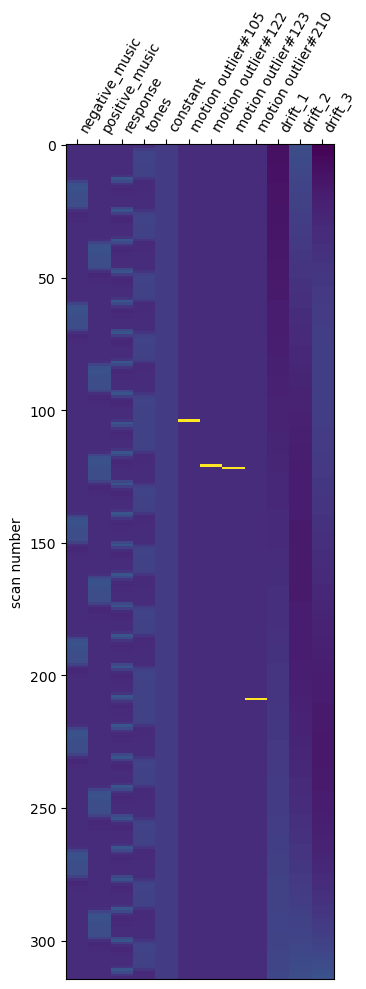

In [40]:
# add drift
design_mat_drift = design_mat_outlier.copy()
from nilearn.glm.first_level.design_matrix import _make_drift

column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.asarray(list(range(0, 315, 1))), order=3, high_pass=None)
for (col, name) in zip(column_values.T, column_names):
    design_mat_drift[name] = col
plot_design_matrix(design_mat_drift)

In [41]:
fmri_glm_outlier = fmri_glm_outlier.fit(dpath, design_matrices=[design_mat_outlier])
fmri_glm_drift = fmri_glm_drift.fit(dpath, design_matrices=[design_mat_drift])

### GLM : condition and beta stat

In [42]:
# Create the dictionary of the conditions

def create_conditions(num_zeros):
    # Define the conditions
    conditions = {
        'neg_music': np.zeros(num_zeros, dtype=int),
        'pos_music': np.zeros(num_zeros, dtype=int),
        'response': np.zeros(num_zeros, dtype=int),
        'tones': np.zeros(num_zeros, dtype=int),
        'constant' : np.zeros(num_zeros, dtype=int),
    }
    
    # Set the position of 1 for each condition
    conditions['neg_music'][0] = 1    
    conditions['pos_music'][1] = 1    
    conditions['response'][2] = 1     
    conditions['tones'][3] = 1  
    conditions['constant'][4] = 1 
    
    return conditions 

conditions = create_conditions(9)
display(conditions)
conditions_drift = create_conditions(12)
display(conditions_drift)

{'neg_music': array([1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'pos_music': array([0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'response': array([0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'tones': array([0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'constant': array([0, 0, 0, 0, 1, 0, 0, 0, 0])}

{'neg_music': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'pos_music': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'response': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'tones': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'constant': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])}

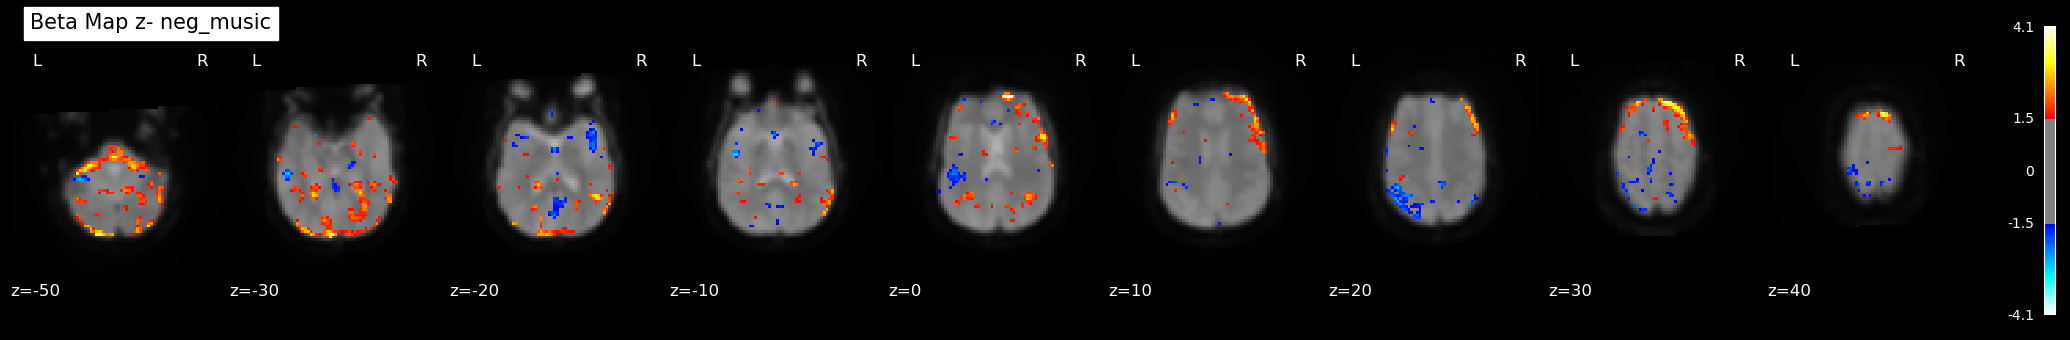

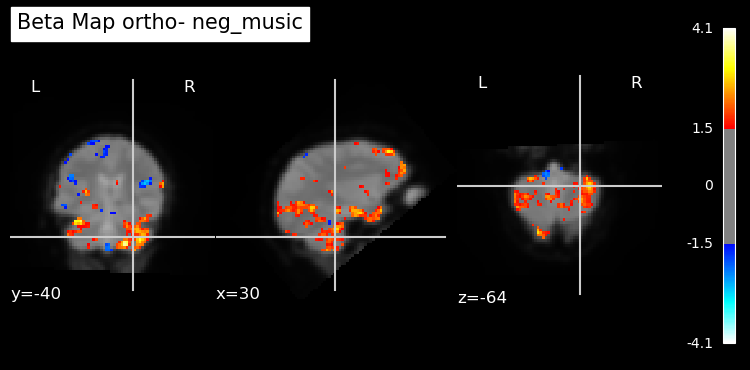

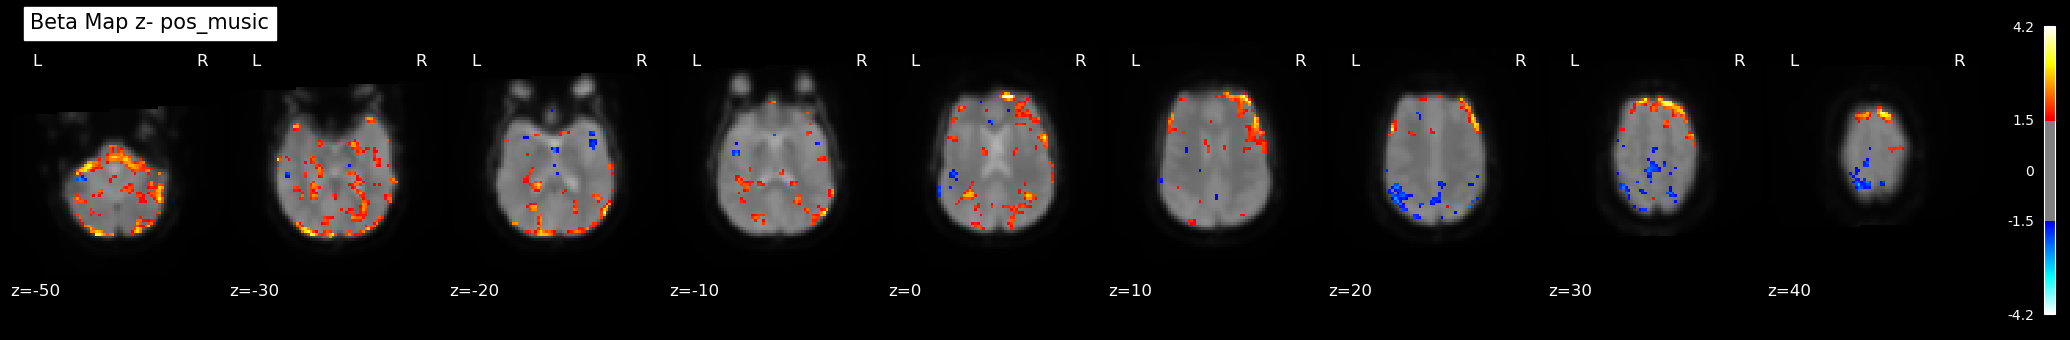

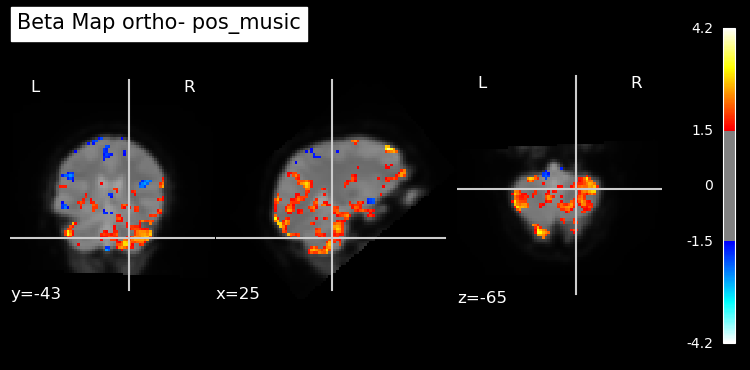

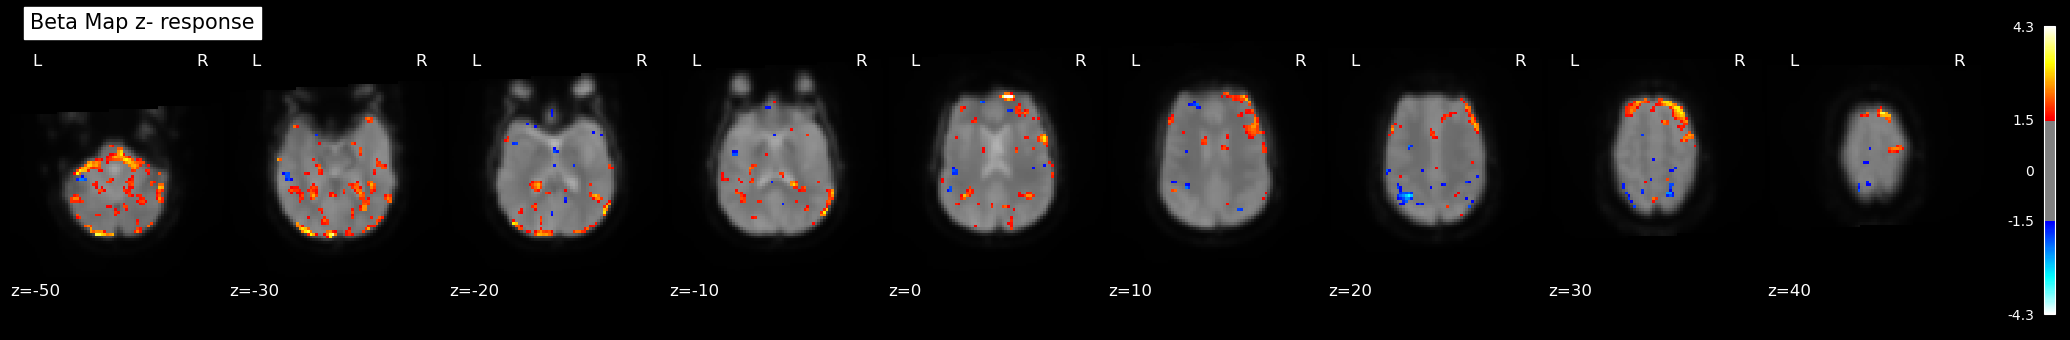

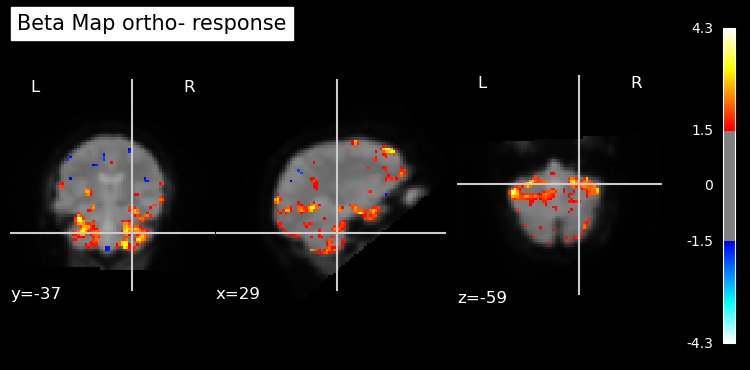

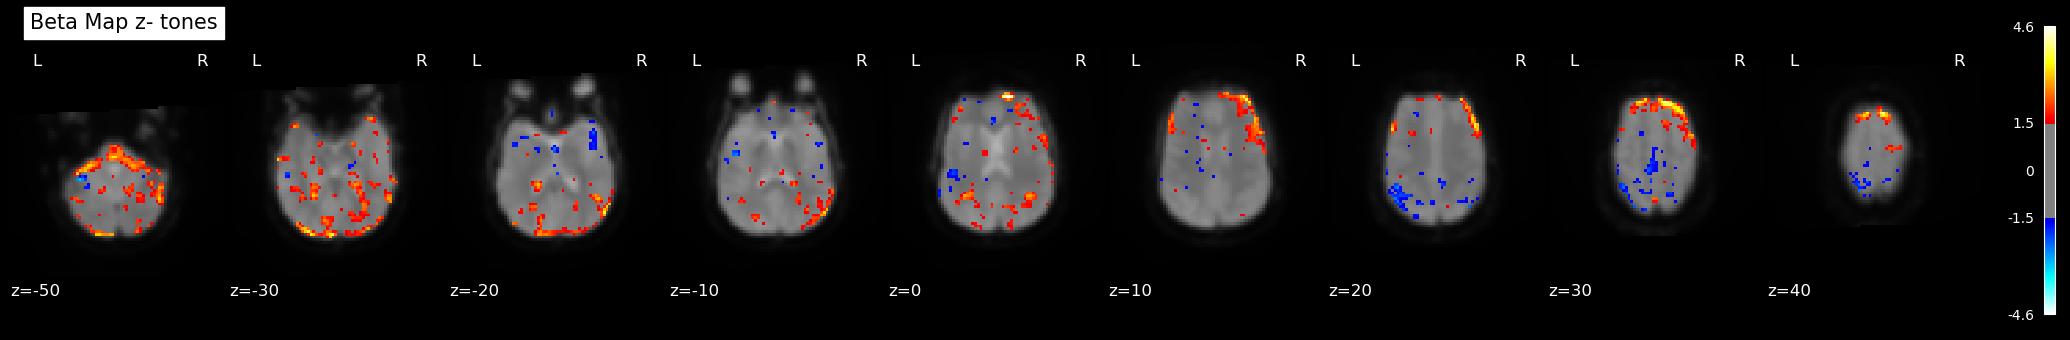

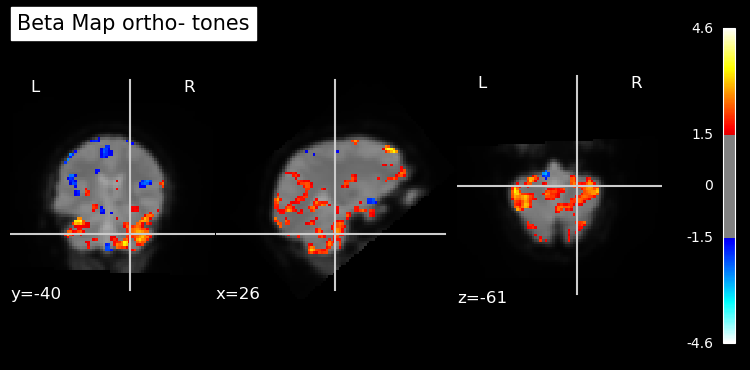

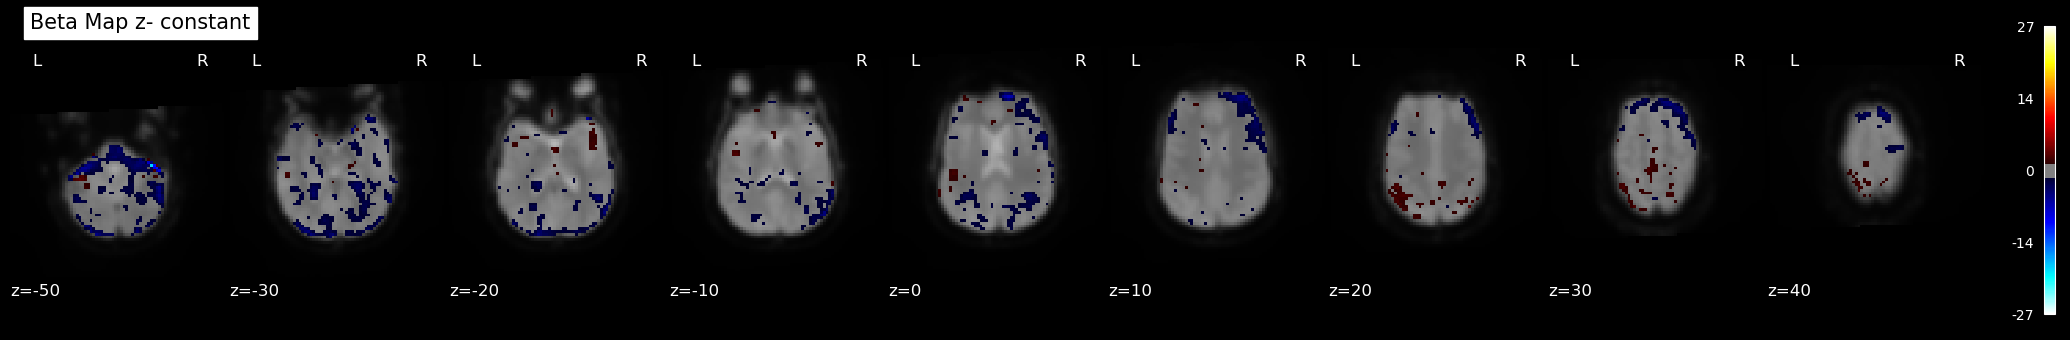

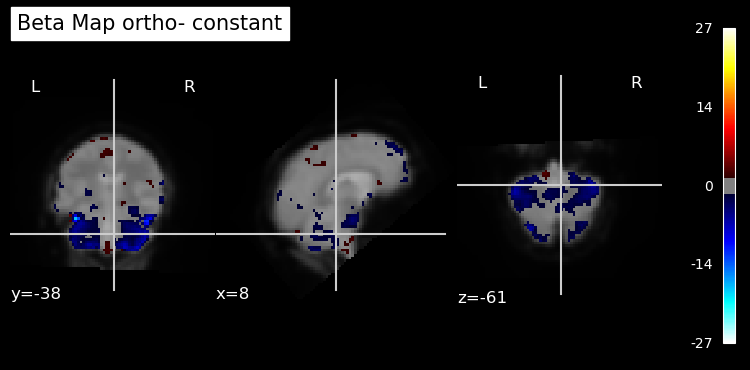

In [43]:
def betamaps(model,conditions) :
    for name in conditions :
        beta_maps = model.compute_contrast(conditions[name], output_type='z_score')
        mean_img_ = mean_img(dpath),
        plot_stat_map(beta_maps,bg_img=mean_img_[0],display_mode='z',cut_coords=[-50,-30,-20,-10,0,10,20,30,40], title="Beta Map z- {}".format(name), threshold=1.5)

        plot_stat_map(beta_maps,bg_img=mean_img_[0],display_mode='ortho', title="Beta Map ortho- {}".format(name), threshold=1.5)

betamaps(fmri_glm_outlier,conditions)

### GLM : contrast pos vs neg

<Axes: label='conditions'>

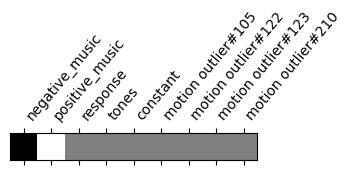

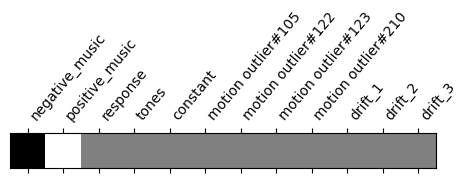

In [44]:
pos_neg_contrast = conditions['pos_music'] - conditions['neg_music']
pos_neg_contrast_drift = conditions_drift['pos_music'] - conditions_drift['neg_music']

plot_contrast_matrix(pos_neg_contrast, design_matrix=design_mat_outlier)
plot_contrast_matrix(pos_neg_contrast_drift, design_matrix=design_mat_drift)

### Run GML

In [45]:
z_map = fmri_glm_outlier.compute_contrast(pos_neg_contrast,
                                  output_type='z_score')

z_map_path = op.join(preproc_root, subject, 'func', 'sub-{}_z_map.nii.gz'.format(subjectID))
nib.save(z_map, z_map_path)

z_map_drift = fmri_glm_drift.compute_contrast(pos_neg_contrast_drift,
                                  output_type='z_score')

z_map_path_drift = op.join(preproc_root, subject, 'func', 'sub-{}_z_map_drift.nii.gz'.format(subjectID))
nib.save(z_map_drift, z_map_path_drift)

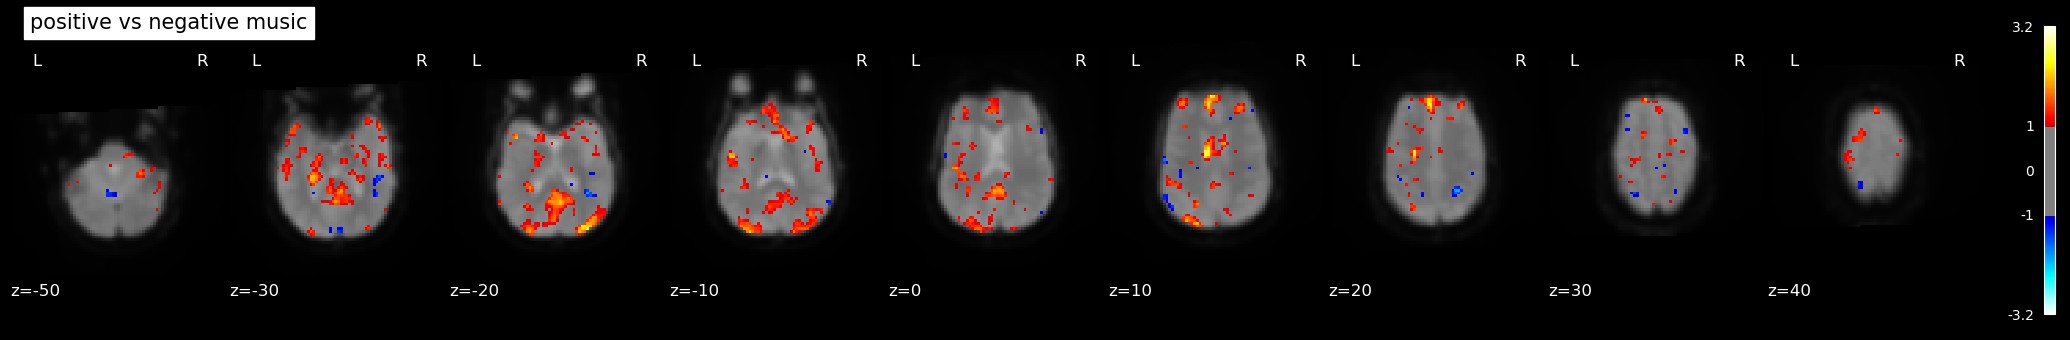

In [46]:
mean_img_ = mean_img(dpath),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=1.0,
              display_mode='z',cut_coords=[-50,-30,-20,-10,0,10,20,30,40],  black_bg=True,
              title='positive vs negative music')

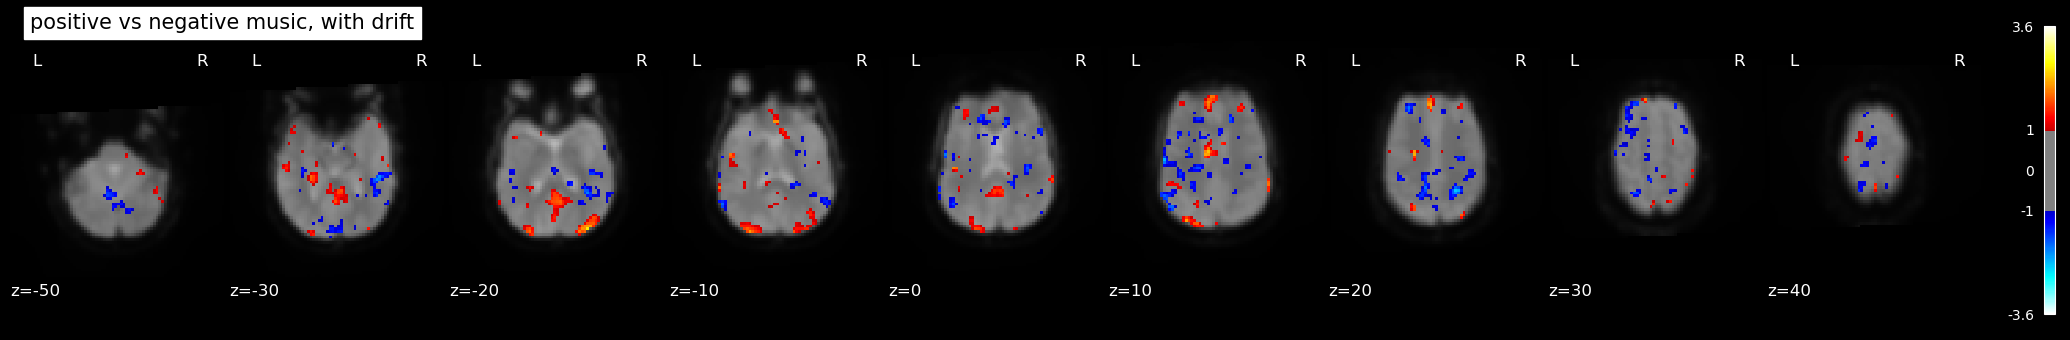

In [47]:
mean_img_ = mean_img(dpath),
plot_stat_map(z_map_drift, bg_img=mean_img_[0], threshold=1.0,
              display_mode='z', cut_coords=[-50,-30,-20,-10,0,10,20,30,40], black_bg=True,
              title='positive vs negative music, with drift')

### Activation map in MNI space

In [48]:
z_map_path_mni = op.join(preproc_root, subject, 'func', 'sub-{}_z_map_mni.nii.gz'.format(subjectID))
z_map_path_mni_cut = op.join(preproc_root, subject, 'func', 'sub-{}_z_map_mni_cut.nii.gz'.format(subjectID))
z_map_path_affined_mni= op.join(preproc_root, subject, 'func', 'sub-{}_z_map_affined_mni.nii.gz'.format(subjectID))

if RERUN :
    applyxfm(src=z_map_path,ref=reference,mat =func_to_mni_mat,out=z_map_path_mni)
    applyxfm(src=z_map_drift,ref=reference,mat =func_to_mni_mat,out=z_map_path_affined_mni)

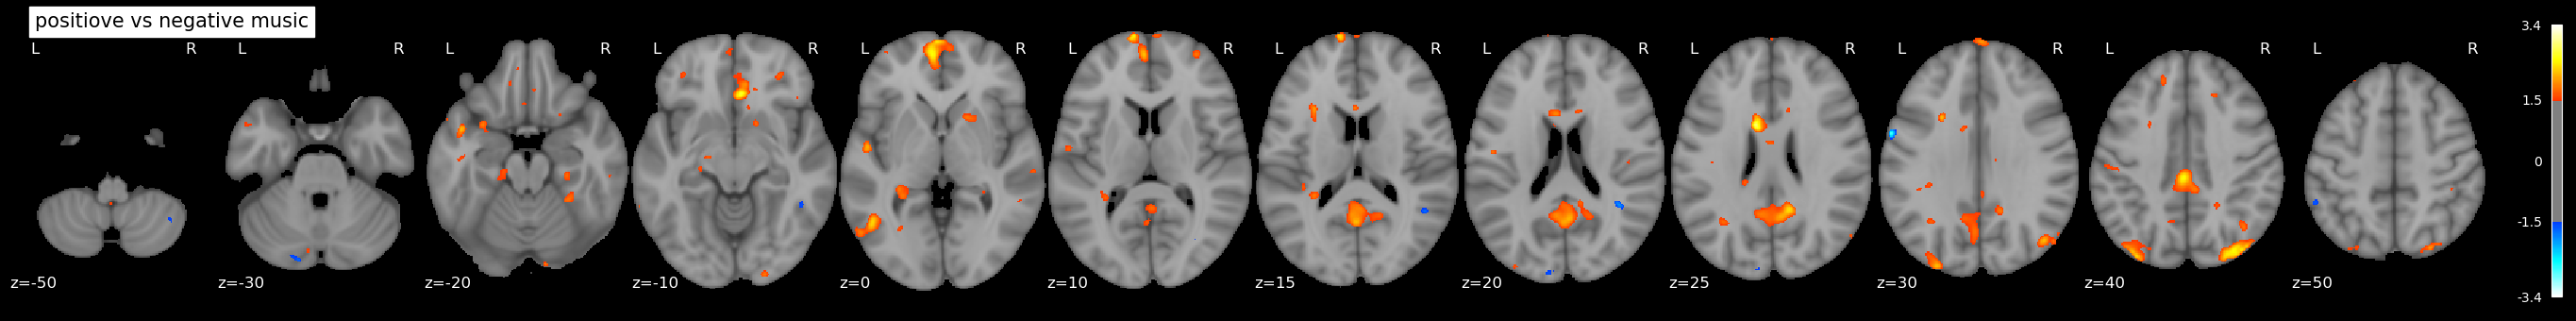

In [49]:
mean_img_ = mean_img(reference),
stat_map = plot_stat_map(nib.load(z_map_path_mni), bg_img=mean_img_[0], threshold=1.5,
              display_mode='z', cut_coords=[-50,-30,-20,-10,0,10,15,20,25,30,40,50], black_bg=True,
              title='positiove vs negative music')

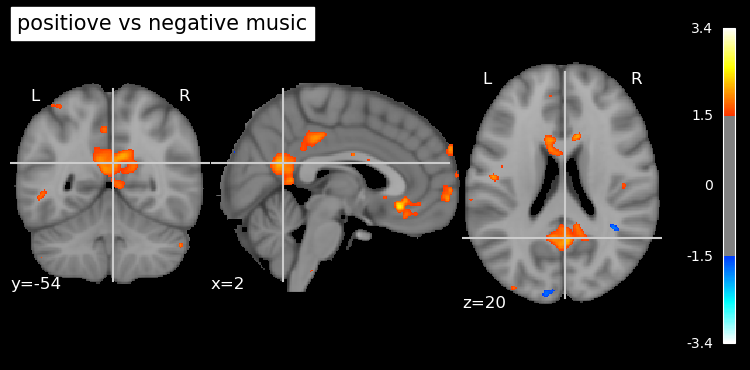

In [50]:
mean_img_ = mean_img(reference),
stat_map = plot_stat_map(nib.load(z_map_path_mni), bg_img=mean_img_[0], threshold=1.5,
              display_mode='ortho', black_bg=True,
              title='positiove vs negative music')

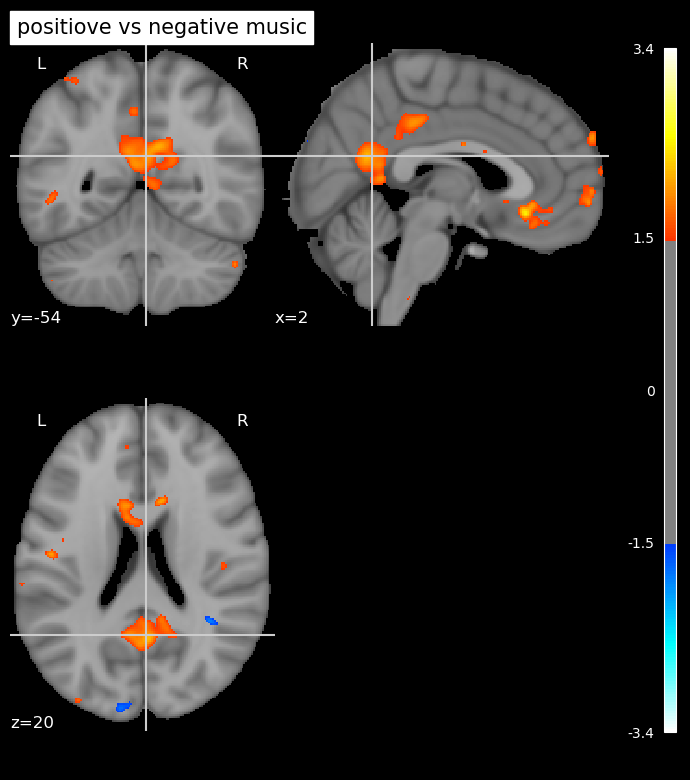

In [51]:
mean_img_ = mean_img(reference),
stat_map = plot_stat_map(nib.load(z_map_path_mni), bg_img=mean_img_[0], threshold=1.5,
              display_mode='tiled', black_bg=True,
              title='positiove vs negative music')

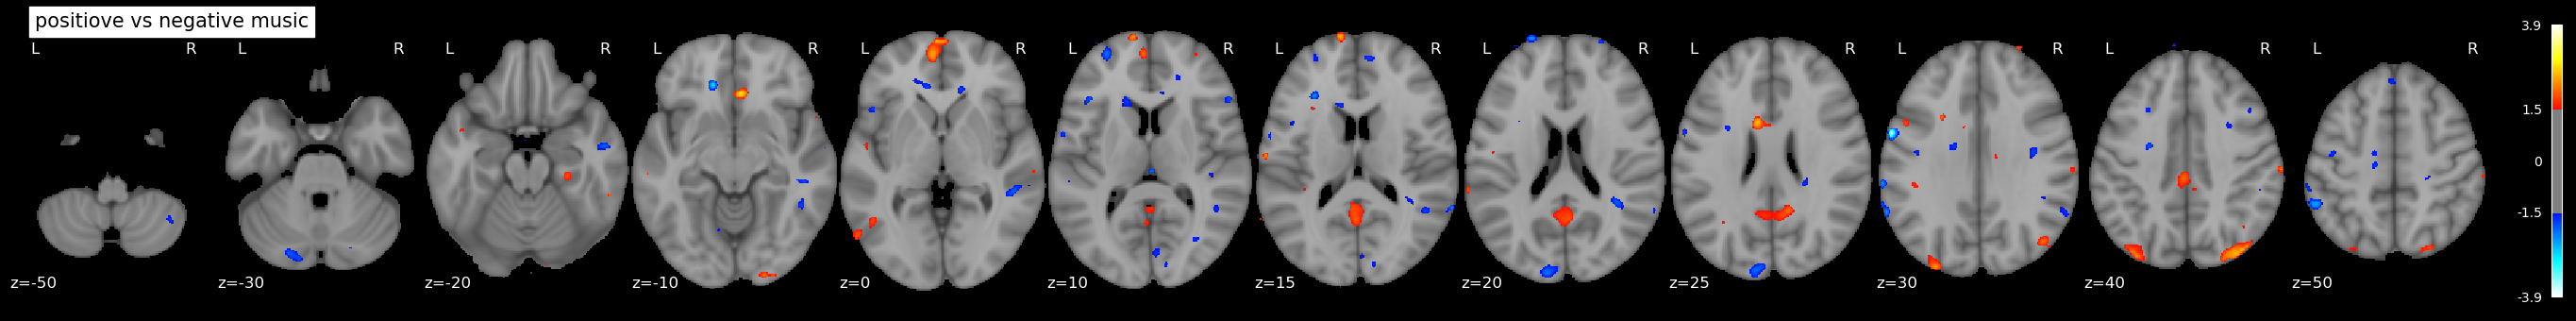

In [52]:
mean_img_ = mean_img(reference),
plot_stat_map(nib.load(z_map_path_affined_mni), bg_img=mean_img_[0], threshold=1.5,
              display_mode='z', cut_coords=[-50,-30,-20,-10,0,10,15,20,25,30,40,50], black_bg=True,
              title='positiove vs negative music')

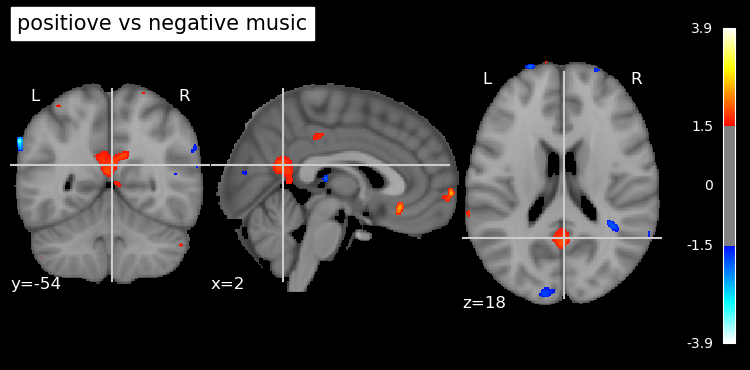

In [53]:
mean_img_ = mean_img(reference),
plot_stat_map(nib.load(z_map_path_affined_mni), bg_img=mean_img_[0], threshold=1.5,
              display_mode='ortho', black_bg=True,
              title='positiove vs negative music')

### Overlapping an atlas

In [ ]:
atlas = op.expandvars('$FSLDIR/data/atlases/MNI/MNI-maxprob-thr25-1mm.nii.gz')
 #subprocess.run(['fslmaths', z_map_path_mni, '-thr', '1.5', z_map_path_mni_cut])
 #fsleyesDisplay.load(reference)
 #fsleyesDisplay.load(atlas)
 #fsleyesDisplay.setOverlayCmap(1,'Render3')
 #fsleyesDisplay.load(z_map_path_mni_cut)
 #fsleyesDisplay.setOverlayCmap(2, 'Hot')

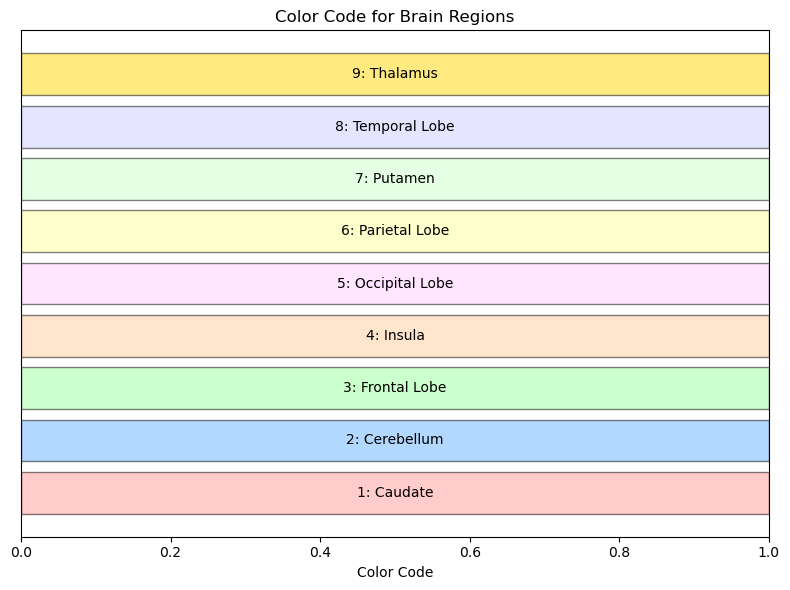

In [58]:
regions = {
    1: ('Caudate', '#FF9999'),      # Light red
    2: ('Cerebellum', '#66B3FF'),   # Light blue
    3: ('Frontal Lobe', '#99FF99'),  # Light green
    4: ('Insula', '#FFCC99'),       # Light orange
    5: ('Occipital Lobe', '#FFCCFF'), # Light pink
    6: ('Parietal Lobe', '#FFFF99'), # Light yellow
    7: ('Putamen', '#CCFFCC'),      # Pale green
    8: ('Temporal Lobe', '#CCCCFF'), # Pale blue
    9: ('Thalamus', '#FFD700')      # Gold
}

def generate_colors(num_colors):
    return plt.cm.viridis(range(num_colors))  # Using the viridis colormap

def create_region_color_mapping(names):
    num_colors = len(names)
    colors = generate_colors(num_colors)
    
    # Convert RGBA to HEX format
    hex_colors = ['#' + ''.join(f'{int(c*255):02x}' for c in color[:3]) for color in colors]
    
    mapping = {}
    for i, (name, color) in enumerate(zip(names, hex_colors)):
        mapping[i + 1] = (name, color)  # Using i + 1 for numbering
    return mapping

aalregions = create_region_color_mapping(aal_labels)
# Extract only the colors from the regions dictionary
colors = [color for name, color in regions.values()]

# Create a custom colormap
custom_cmap = ListedColormap(colors)


# Create a figure for the color-region correspondence plot
plt.figure(figsize=(8, 6))
plt.title('Color Code for Brain Regions')

# Create a horizontal bar for each region
for idx, (number, (name, color)) in enumerate(regions.items()):
    plt.barh(idx, 1, color=color, edgecolor='black',alpha = 0.5)
    plt.text(0.5, idx, f'{number}: {name}', ha='center', va='center', fontsize=10, color='black')

# Set the x-axis limits and remove y-ticks
plt.xlim(0, 1)
plt.yticks([])
plt.xlabel('Color Code')
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

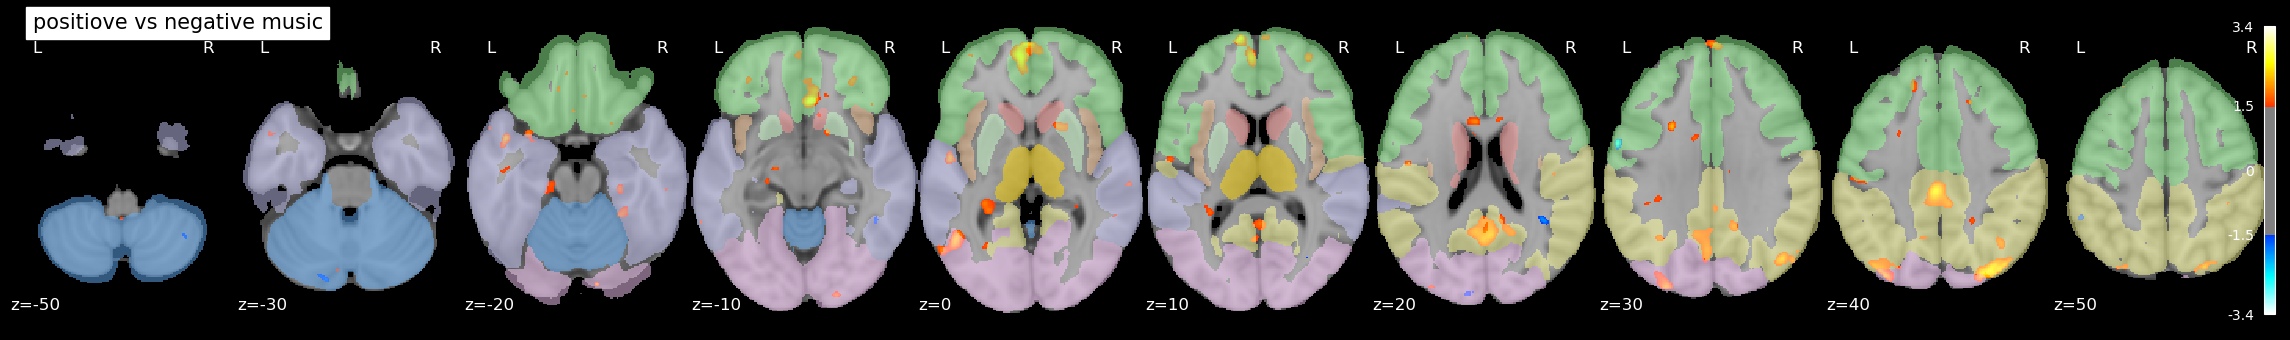

In [111]:
mean_img_ = mean_img(reference),
mean_atlas = mean_img(aal_atlas),
stat_map = plot_stat_map(nib.load(z_map_path_mni), bg_img=mean_img_[0], threshold=1.5,
              display_mode='z', cut_coords=[-50,-30,-20,-10,0,10,20,30,40,50], black_bg=True,
              title='positiove vs negative music')
stat_map.add_overlay(mean_atlas[0], cmap=custom_cmap,alpha = 0.5)

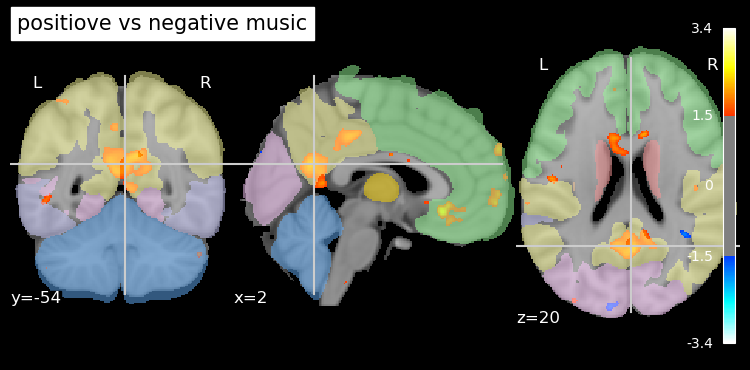

In [112]:
mean_img_ = mean_img(reference),
mean_atlas = mean_img(aal_atlas),
stat_map = plot_stat_map(nib.load(z_map_path_mni), bg_img=mean_img_[0], threshold=1.5,
              display_mode='ortho', black_bg=True,
              title='positiove vs negative music')
stat_map.add_overlay(mean_atlas[0], cmap=custom_cmap,alpha = 0.5)

We observe activations in the Parietal lobe and little activation in the prefontal lobe. To be more precise, we will overlay the result with the AAL parcelation on fsl. 

### Overlapping the AAL atlas on FSL for more precisions

In [54]:
aal_atlas = datasets.fetch_atlas_aal()
aal_path = aal_atlas['maps'] 
# fsleyesDisplay.resetOverlays()
subprocess.run(['fslmaths', z_map_path_mni, '-thr', '1.5', z_map_path_mni_cut])
fsleyesDisplay.load(reference)
fsleyesDisplay.load(aal_path)
fsleyesDisplay.setOverlayCmap(1,'Render3')
fsleyesDisplay.load(z_map_path_mni_cut)
fsleyesDisplay.setOverlayCmap(2, 'Hot')

In [62]:
aal_labels = aal_atlas['labels']
aal_indice = aal_atlas['indices']
aal_dict = {index: label for index, label in zip(aal_indice, aal_labels)}
display(aal_dict)

{'2001': 'Precentral_L',
 '2002': 'Precentral_R',
 '2101': 'Frontal_Sup_L',
 '2102': 'Frontal_Sup_R',
 '2111': 'Frontal_Sup_Orb_L',
 '2112': 'Frontal_Sup_Orb_R',
 '2201': 'Frontal_Mid_L',
 '2202': 'Frontal_Mid_R',
 '2211': 'Frontal_Mid_Orb_L',
 '2212': 'Frontal_Mid_Orb_R',
 '2301': 'Frontal_Inf_Oper_L',
 '2302': 'Frontal_Inf_Oper_R',
 '2311': 'Frontal_Inf_Tri_L',
 '2312': 'Frontal_Inf_Tri_R',
 '2321': 'Frontal_Inf_Orb_L',
 '2322': 'Frontal_Inf_Orb_R',
 '2331': 'Rolandic_Oper_L',
 '2332': 'Rolandic_Oper_R',
 '2401': 'Supp_Motor_Area_L',
 '2402': 'Supp_Motor_Area_R',
 '2501': 'Olfactory_L',
 '2502': 'Olfactory_R',
 '2601': 'Frontal_Sup_Medial_L',
 '2602': 'Frontal_Sup_Medial_R',
 '2611': 'Frontal_Med_Orb_L',
 '2612': 'Frontal_Med_Orb_R',
 '2701': 'Rectus_L',
 '2702': 'Rectus_R',
 '3001': 'Insula_L',
 '3002': 'Insula_R',
 '4001': 'Cingulum_Ant_L',
 '4002': 'Cingulum_Ant_R',
 '4011': 'Cingulum_Mid_L',
 '4012': 'Cingulum_Mid_R',
 '4021': 'Cingulum_Post_L',
 '4022': 'Cingulum_Post_R',
 '4101

prefont cortex 
=> 4002 Cingulum_Ant (expected)
=> 2601,2611/2612 Frontal_Sup_Medial Frontal_Med_Orb (high level processing)
parietal :
4011/4012 => Cingulum_Mid , 
6301/6302 => Precuneus
8201 => Temporal_Mid_L (auditory residual)